In [4]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

amplitude symmetries意義?

In [14]:
n = 3.4
w = 1 
r = 1
pad = 4
dpm1 = 2 

cell = 2 * (w + r + pad + dpm1)
cell_size = mp.Vector3(cell,cell) 

pml_layers = [mp.PML(dpm1)]

c1 = mp.Cylinder(radius = r + w,material=mp.Medium(index=n))
c2 = mp.Cylinder(radius = r)
geometry = [c1,c2]

fcen = 0.118

sources = [ mp.Source(mp.ContinuousSource(fcen) , mp.Ez , center = mp.Vector3(r+0.1)),
           mp.Source(mp.ContinuousSource(fcen) , mp.Ez , center = mp.Vector3(-(r+0.1)) , amplitude=-1,),
         ]

symmetries = [mp.Mirror(mp.X, phase = -1), mp.Mirror(mp.Y, phase = +1)]

In [16]:
sim = mp.Simulation(
      cell_size = cell_size,
      geometry = geometry,
      sources = sources,
      resolution = 10,
      force_complex_fields = True,
      symmetries = symmetries,
      boundary_layers = pml_layers,)

     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


<function matplotlib.pyplot.show(close=None, block=None)>

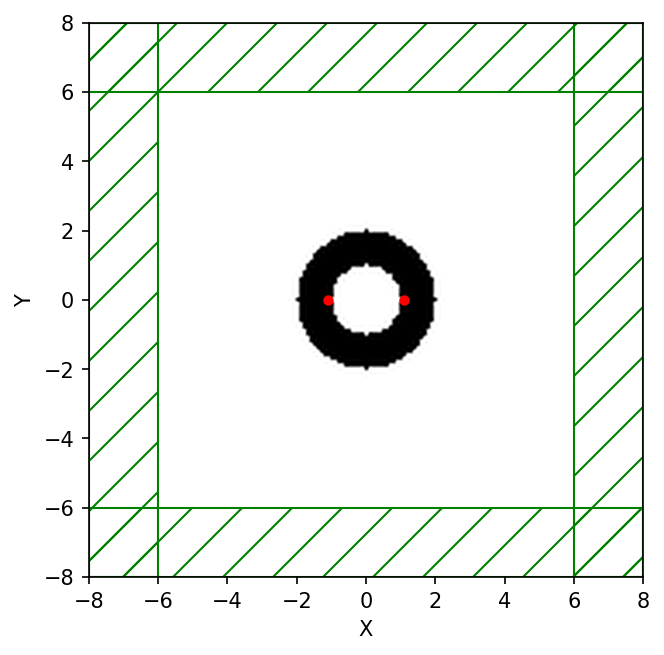

In [20]:
f = plt.figure(dpi = 150)
sim.plot2D(ax = f.gca())
plt.show